In [3]:
!python -m pip install matplotlib
!python -m pip install scipy
!python -m pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 3.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 3.8 MB/s eta 0:00:004.1 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.9 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.9 MB/s eta 0:00:004.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 4.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 4.0 MB/s eta 0:00:000:00:01m eta 0:00:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 3.9 MB/s eta 0:00:00m eta 0:00:010:00:01


In [3]:
import matplotlib.pyplot as plt
from itertools import accumulate
from scipy.stats import norm,median_abs_deviation,chi2
from statistics import mean,variance,median
from math import sqrt,log,inf,exp,sin,pi
import csv
import time
from functools import reduce
from random import seed
import numpy as np

## Background

This notebook introduces a Python API that provides algorithms for undertaking changepoint detection in ordered univariate data sets. These core algorithms take as inputs cost functions, which in practice typically, (but not necessarily), take the form

$f : \cal{N} \times \cal{N} \rightarrow \cal{R}$ 

subject to the constraint $f(a,b) + f(b,c) <= f(a,c)$ where $a \leq b \leq c$.

The API has adopted this approach so that the new cost functions can easily implemented for use with the core methods. 

More generally the form of the cost function is

$f : X \times X \rightarrow Y$ where $X$ and $Y$ are sets with a sense of (total) ordering (e.g. there exists a "< like" relation for the sets).  

### An example cost function

A cost function does not necessarily have to be a python function. It only has to be a "callable" ("invokable") object (which of course includes standard Python functions). A versatile template for a such a callable object which satisfies the general requirements of the cost functions outlined previously is shown below.

```python
class cost_function :
    def __init__(self,data,...) : # ... represent extra parameters where required
        # setup function state here
    def __call__(self,a,b) :
        # calculate c as a function of a and b
        return c
```

Here is a concrete example of a cost function which can be used in conjunction with the core algorithms to detect changes in mean in a data set that has an underlying uniform normal distribution. 

In [319]:
class normal_mean :
    def __init__(self,X,minseglen=0) :
        self.X = X
        self.SX = [0] + list(accumulate(X))
        self.SXX = [0] + list(accumulate([x*x for x in X]))
        self.minseglen = minseglen
    def __call__(self,a,b) :
        if b - a + 1 < self.minseglen :
            return inf
        val = self.SX[b+1] - self.SX[a]
        val *= val
        val /= (b - a + 1)
        val = -val
        val += self.SXX[b+1] - self.SXX[a]
        return val

This stateful function (functor) can be used as follows.

#### generate some test data

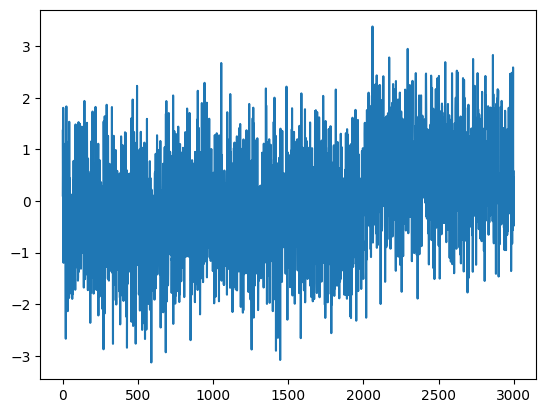

In [320]:
np.random.seed(0)
X = [0.0 for i in range(2000)] + [1.0 for i in range(1000)]
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z] # normalise the data
plt.plot(Z)
plt.show()

#### instantiate the functor

In [321]:
f = normal_mean(Z,10)

#### call the functor

In [322]:
f(10,27)

18.4773841219649

#### demonstrate a basic characteristic of the cost function

In [230]:
f(0,9) + f(10,19) <= f(0,20)


True

#### visualise the cost function

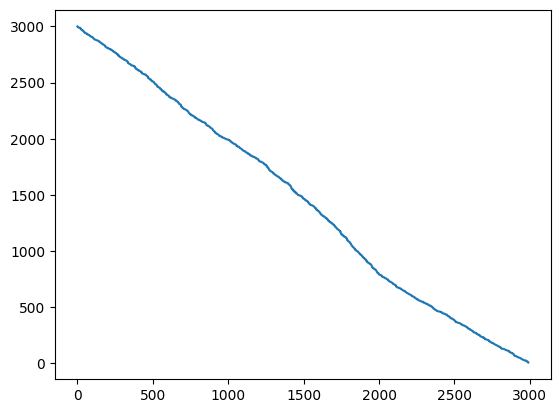

In [231]:
plt.plot([f(i,len(Z)-1) for i in range(len(Z))])

Notice that in this setting the data being studied becomes a parameter of the cost function. The core algorithms that are introduced shortly are only "aware" of the cost functions and not the underlying data.

## Core algorithms

### split

The first core algorithm, **split**, is quite primitive (and simple) but forms the basis for most of the other algorithms.

$split : (\cal{N} \times \cal{N} \rightarrow \cal{R},\cal{N} \times \cal{N} \rightarrow \cal{R},S \subset{\cal{}N}) \rightarrow \cal{N} \times \cal{R}$

In other words, $f$ and $g$ are cost functions and $S$ is a set of natural numbers.

More specifically, for $f,g \in \cal{N} \times \cal{N} \rightarrow \cal{R}$ and $S$, split returns a tuple $(k,c)$ where $k \in S$ is such that $f(\min(S),k) + g(k,\max(S)) = c$ is minimized.  

More concretely.

In [226]:
def split(f,g,R) :
    ra,rb = min(R),max(R)
    return min([(r,f(ra,r) + g(r,rb)) for r in R],key = lambda x : x[1])
    

If the computational complexities of $f$ and $g$ are $\cal{O}(f)$ and  $\cal{O}(g)$ respectively, then the complexity of split is $\cal{O}(|S|) \times \max(\cal{O}(f),\cal{O}(g))$

#### finding a changepoint with split

A single changepoint may be located using split by setting $g$ = $f$ and $S = {\rm dom}(f)$.

In [232]:
S = list(range(len(Z)))
split(f,f,S)

(2007, 2455.7458644969765)

Which can be confirmed visually.

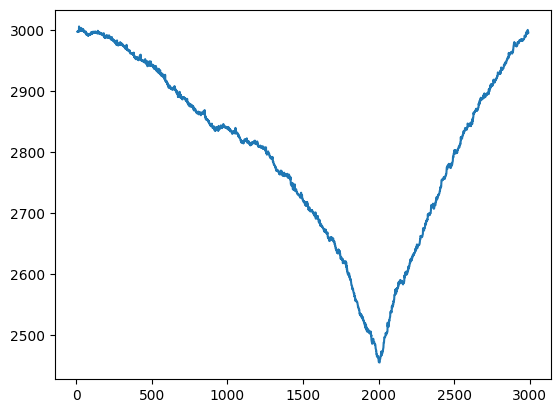

In [233]:
plt.plot([f(min(S),i) + f(i,max(S)) for i in S])

Note that the split algorithm is not "aware" of the underlying data - only the cost functions and a subset of the cost functions domain.

### amoc

The core algorithm **amoc** employs split to find a single changepoint subject to a threshold (penalty) being satisfied.

$amoc : (\cal{N} \times \cal{N} \rightarrow \cal{R},S \subset{\cal{}N},\cal{R}) \rightarrow \cal{N} \times \cal{R}$

More specifically, if $(k,c) = {\rm split}(g,g,S)$ then ${\rm amoc}(g,S,\beta) = (k,c+\beta)$ if $g(\min(S),\max(S)) - c > \beta$ or $(0,g(\min(S),\max(S))$ otherwise.

More concretely.

In [234]:
def amoc(g,R,beta) :
    def f(i,j) : return 0 if i == j else g(i,j-1) + beta
    return split(f,g,R)
    

Notice that, internally, amoc defines a new cost function $f$ in terms of the user defined cost function $g$.

It follows from the analysis of split that the  complexity of amoc is $\cal{O}(|S|) \cal{O}(f)$

####  using amoc

In [235]:
beta = 2*log(len(S)) # a good choice for beta
amoc(f,S,beta)

(2002, 2471.1910121909204)

In [236]:
beta = inf # prevent changepoint detection
amoc(f,S,beta)

(0, 2998.99999999999)

### op

The core method **op** can be used to detect mutiple changepoints in a data sequence. It is based on the optimal partitioning algorithm described in **\[1\]**. This algorithm uses an efficient scheme to examine a subset of all possible contiguous segmentations of the sequence that is $\cal{O}(n^2)$ in the size of the sequence.

$op : (\cal{N} \times \cal{N} \rightarrow \cal{R},S \subset{\cal{}N},\cal{R}_{\geq 0}) \rightarrow (\cal{N} \rightarrow (\cal{N} \times \cal{R}))$

More specifically

**Algorithm** op \
**Inputs** $g : \cal{N} \times \cal{N} \rightarrow \cal{R}$, $R$ an ordered subset of $\cal{N}$ and $\beta \in \cal{R}_{\geq 0}$ \
&nbsp;&nbsp;&nbsp;&nbsp;$r_{a} = \min(R)$ \
&nbsp;&nbsp;&nbsp;&nbsp;$s \leftarrow f \leftarrow \{\}$ \
&nbsp;&nbsp;&nbsp;&nbsp;$c \leftarrow -\beta$ \
&nbsp;&nbsp;&nbsp;&nbsp;$T \leftarrow \left[\right]$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _where_ $[]$ _is the empty ordered set_ \
&nbsp;&nbsp;&nbsp;&nbsp;for $r \in R$ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$f \leftarrow f \cup \{((r_{a},r),c + \beta)\}$ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$T \leftarrow T \cup [r]$ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbspbs;&nbsp;&nbsp;$(k,c) \leftarrow {\rm split}(f,g,T)$ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s \leftarrow s \cup \{(k,c)\}$ \
&nbsp;&nbsp;&nbsp;&nbsp;return $s$





Note that the pseudo code for op employs the mathematical notion of a function as being a set of ordered pairs
insofar that $f \leftarrow f \cup \{(r_{a},r),c + \beta)\}$ makes sense and $f(r_{a},r) = c + \beta$. This is not supported directly by most languages so, for purposes of consistency between concept and code, the API offers the following implementation built on a dictionary. 

In [237]:
class point_function :
    def __init__(self) :
        self.D = {}
    def union(self,S) :
        for x,y in S :
            self.D[x] = y
    def __call__(self,*args) :
        x = args
        if len(x) == 1 :
            x = x[0]
        return self.D[x]
    def domain(self) :
        return list(self.D.keys())
    def image(self) :
        return list(self.D.values())

The value returned by op is a function which maps an element $r$ of  $R$ (a position in the data sequence) to an ordered pair $(k,c)$ where $k < r$  indicates the position of the most recent changepoint prior to $r$ and $c$ is the penalised cost of the asociated segmentation $[{\rm min}(R),k]$. A possible python implementation for op is then.

In [11]:
def op(g,R,beta) :
    ra = min(R)
    f = point_function()
    s = point_function()
    T = []
    segmentation = {}
    cost = -beta
    for r in R :
        f.union({((ra,r),cost + beta)})
        T.append(r)
        index,cost = split(f,g,T)
        s.union({(r,(index,cost))})
    return s

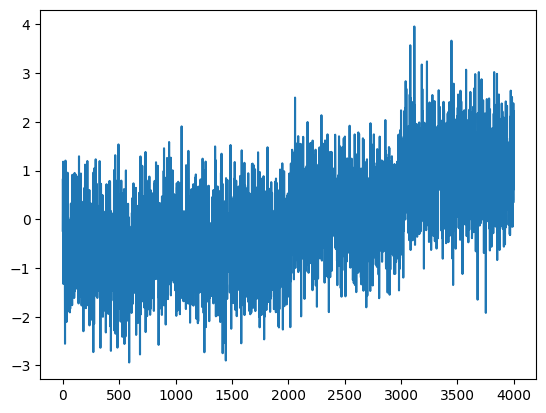

In [20]:
np.random.seed(0)
X = [0.0 for i in range(2000)] + [1.0 for i in range(1000)] + [2.0 for i in range(1000)]
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z] # normalise the data
plt.plot(Z)
plt.show()

In [21]:
g = normal_mean(Z)
R = list(range(len(Z)))
beta = 2*log(len(Z))
res = op(g,R,beta)

In [22]:
res(2999)

(2002, 1729.8639532893874)

In [23]:
res(2002)

(0, 1163.7939424911538)

```python
def op(g,R,beta) :
    ra = min(R)
    f = point_function()
    s = point_function()
    T = []
    segmentation = {}
    cost = -beta
    for r in R :
        f.union({((ra,r),cost + beta)})
        T.append(r)
        index,cost = split(f,g,T)
        s.union({(r,(index,cost))})
    return s
```

offering the following usage.

```python
np.random.seed(0)
X = [0.0 for i in range(2000)] + [1.0 for i in range(1000)] + [2.0 for i in range(1000)]
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z] # normalise the data
```

```python
g = normal_mean(Z)
R = list(range(len(Z)))
beta = 2*log(len(Z))
res = op(g,R,beta)
```

```python
res(2999)
```
(2002, 1729.8639532893874)

```python
res(2002)
```
(0, 1163.7939424911538)

### sop

The API sets out to allow the core algorithms to be as reusable as possible. To this end, the op algorithm can be implemented sequentially allowing it to be updated with new data as an analysis (or other algorithm) progresses. 

**Initialisation**\
&nbsp;&nbsp;&nbsp;&nbsp;$S.r_{a} = S.c = S.\beta = null$ \
&nbsp;&nbsp;&nbsp;&nbsp;$S.s \leftarrow S.f \leftarrow \{\}$ \
&nbsp;&nbsp;&nbsp;&nbsp;$S.T \leftarrow \left[\right]$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; \\\\ _where_ $[]$ _is the empty ordered set_ \
\
**Algorithm** sop \
**Inputs** $S$, $g$, $R$, $\beta$ \
&nbsp;&nbsp;&nbsp;&nbsp;if $S.r_{a} == null$ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S.r_{a} = \min(R)$ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S.c = -S.\beta$ \
&nbsp;&nbsp;&nbsp;&nbsp; for $r \in R$ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S.f \leftarrow S.f \cup \{((r_{a},r),c + \beta)\}$ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S.T \leftarrow S.T \cup [r]$ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$(k,S.c) \leftarrow {\rm split}(S.f,g,S.T)$ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S.s \leftarrow S.s \cup \{(k,S.c)\}$ \
&nbsp;&nbsp;&nbsp;&nbsp;return $S$

Note that to use sop an external state $S = S_{0}$ has to be initialised with elements as defined for the op algorithm. The sop algorithm updates an existing state $S_{n}$ to an new state $S_{n+|R|}$ using the new information $g$, $R$, and $\beta$. This sequential approach now allows the cost function $g$ and penalty $\beta$ to be modified between calls to sop using information from the previous state $S_{n}$ or other external factors. Whats more, the elements of the state $S_{n}$ can themselves be modified prior to the next invokation of sop to account for the requirements of other algorithms that employ sop. An useful example of the latter case will be introduced shortly.

To implement sop in a weakly dynamically typed language such as python it is probably safer to tie the state $S$ and the algorithm together in a class and provide an update member function to implement the application of sop on the current state. This is done because it is the only way that python can dispatch on a type of the state. Initialisation of the state $S$ is now done during initialisation of a class instance. Here is the concrete example.

In [238]:
class sop :
    def __init__(self) :
        self.fstar = point_function()
        self.f = lambda i,j : self.fstar(j) 
        self.s = point_function()
        self.T = []
        self.rdash = None # the last but one location
    def update(self,g,R,beta) :
        for r in R : 
            if self.rdash == None :
                self.rdash = r
                self.s.union({(r,(r,-beta))})
            self.fstar.union({(r,self.s(self.rdash)[1] + beta)})
            self.T.append(r)
            index,cost = split(self.f,g,self.T)
            self.s.union({(r,(index,cost))})
            self.rdash = r

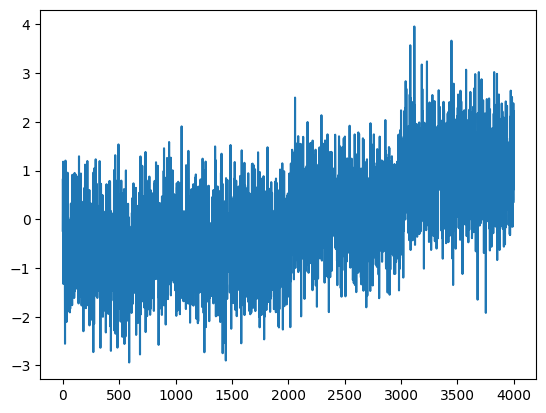

In [239]:
np.random.seed(0)
X = [0.0 for i in range(2000)] + [1.0 for i in range(1000)] + [2.0 for i in range(1000)]
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z] # normalise the data
plt.plot(Z)
plt.show()

In [240]:
g = normal_mean(Z)
beta = 2*log(len(Z))
S = sop()
for r in range(0,len(Z)) : 
      S.update(g,[r],beta)

In [241]:
S.s(2999)

(2002, 1729.8639532893874)

In [242]:
S.s(2002)

(0, 1163.7939424911538)

The API includes a non member version of sop.update. The important distinction between the member and non member versions is that the latter returns the updated state. This can help make code easier to comprehend when multiple operations are composed (chained together) in a client program. 

In [243]:
def update(S,g,R,beta) :
    S.update(g,R,beta)
    return S

#### example

In [244]:
S = sop()
for r in range(0,len(Z)) : 
    S = update(S,g,[r],beta)
S.s(2500)    

(2002, 1462.7219015794724)

### op revisited

The actual API implementation of the non sequentional op is now simply

In [24]:
def op(g,R,beta) :
    S = sop()
    S.update(g,R,beta)
    return S.s

In [25]:
R = list(range(len(Z)))
res = op(g,R,beta)

In [27]:
res(2999)

(2002, 1729.8639532893874)

### cpts

cpts is a utility function to extract the change locations from a function

In [28]:
def cpts(segmentations,rb = None) :
    dom = list(segmentations.domain())
    ra = min(dom)
    if rb == None :
        rb = max(dom)
    index = rb
    locations = []
    while index != ra :
        index,_ = segmentations(index)
        locations.append(index)
    return list(reversed(locations))

#### example

In [29]:
cpts(res)

[0, 2002, 3000]

cpts has a parameter to select a point $r_{b}$. When used, cpts will return the changepoint locations that were determined up to and including the point $r_{b}$ in $R$. 

#### example

See how the changepoint located at 2000 was discovered.

In [51]:
print([cpts(res,i) for i in range(2000,2040)])

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 2002], [0, 2008], [0, 2008], [0, 2008], [0, 2008], [0, 2008], [0, 2008], [0, 2008]]


### prune

The prune algorithm can be used to reduce a set of candidtate changepoint locations in the manner described in **\[2\]**. It is an example of an algorithm that can be used in conjuction with a sequential sop object to modify the state after each update.

In [30]:
def prune(f,g,T,beta) :
    ra,rb = min(T),max(T)
    return [t for t in T if f(ra,t) + g(t,rb) <= f(ra,rb) + beta]        

### pelt

prune and sop can now be combined to create the pelt algorithm developed in *\[2\]*.

In [31]:
def pelt(g,R,beta) :
    S = sop()
    for r in R :
        S.update(g,[r],beta)
        S.T = prune(S.f,g,S.T,beta)
    return S.s

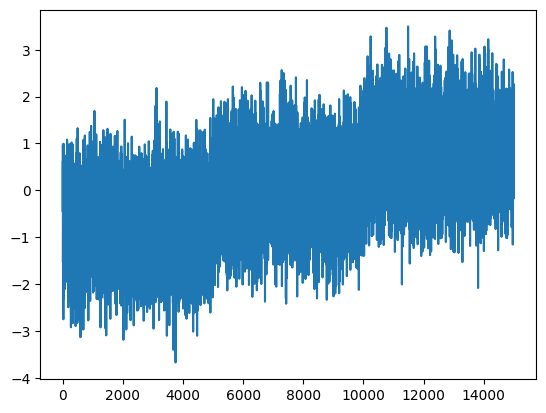

In [32]:
np.random.seed(0)
X = [0.0 for i in range(5000)] + [1.0 for i in range(5000)] + [2.0 for i in range(5000)]
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z] # normalise the data
plt.plot(Z)
plt.show()

In [33]:
R  = list(range(len(Z)))
g = normal_mean(Z)
beta = 2*log(len(Z))

In [34]:
start =  time.perf_counter()
res = op(g,R,beta)
end =  time.perf_counter()
print(cpts(res))
print(end - start)

[0, 5005, 9999]
90.48768841399578


In [35]:
start =  time.perf_counter()
res = pelt(g,R,beta)
end =  time.perf_counter()
print(cpts(res))
print(end - start)

[0, 5005, 9999]
73.04878665199794


## Cost functions - more examples

In [158]:
class linear :
    def __init__(self,X,Y) :
        self.X = X
        self.Y = Y
        self.XY = np.array([X,Y])
    def __call__(self,i,j) :
        if j - i < 2 :
            return 0
        regression = stats.linregress(self.XY[:,i:(j+1)])
        a = regression.slope
        b = regression.intercept
        return stats.chi2.pdf(sum([(y - a*x - b)*(y - a*x - b) for x,y in zip(self.X[i:(j+1)],self.Y[i:(j+1)])]),j-i+1,scale=10)

In [68]:
np.random.seed(0)
X1 = list(range(200))
E1 = norm.rvs(size=len(X1),scale=10)
a1 = 1.6
b1 = 2
Y1 = [a1*x + b1 + e for x,e in zip(X1,E1)]
X2 = [x + len(X1) for x in X1]
E2 = norm.rvs(size=len(X2),scale=10)
a2 = 1.2
b2 = (a1-a2)*X1[-1] + b1 
Y2 = [a2*x + b2 + e for x,e in zip(X2,E2)]
X = X1 + X2
Y = Y1 + Y2


In [69]:
from scipy import stats

In [92]:
res = stats.linregress(X, Y)
Y_hat = [res.slope*x + res.intercept for x in X]

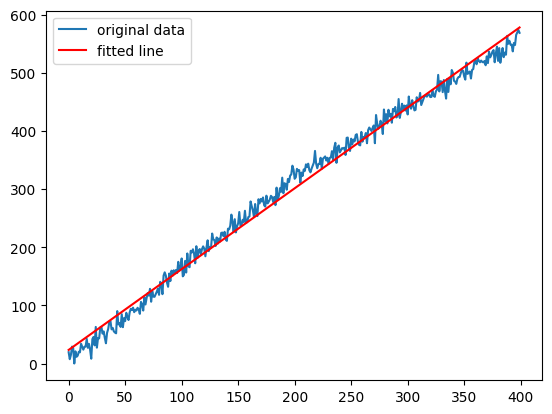

In [152]:
plt.plot(X, Y, label='original data')
plt.plot(X, Y_hat, 'r', label='fitted line')
plt.legend()
plt.show()

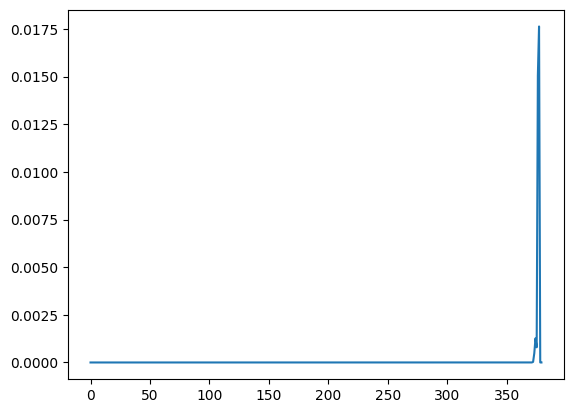

In [159]:
g = linear(X,Y)
plt.plot([g(0,i) + g(i+10,400) for i in range(10,390) ])

In [122]:
split(g,g,list(range(len(X))))

(195, 38499.463049364145)

In [125]:
beta = 10*10*len(X)
res = op(g,list(range(len(X))),0)
#print(cpts(res))

In [126]:
len(res.domain())

400

In [130]:
res(391)

(388, 7700.253905124929)

In [160]:
class npConditional : 
    def __init__(self,X,Q) :
        # Note - this initialisation is O(len(X))
        # determine the quantiles
        n = len(X)
        X_sorted = sorted(X)
        c = -log(2*n-1)
        pK = [(1+exp(c*(-1+2*(k+1)/K-1/K)))**-1 for k in range(K)]
        I = [int((n-1)*p) for p in pK]
        Q = [-inf] + [X_sorted[i] for i in I] + [inf] 
        self.n = n
        k = len(Q)
        # Calculate summary statistics
        self.S = {-1 : tuple((k-1)*[0])}
        for i in range(self.n) :
            self.S[i] = tuple([int(X[i] > a and X[i] <= b) for a,b in zip(Q[:-1],Q[1:])])
        for i in range(self.n) :
            self.S[i] = tuple([self.S[i][j] + self.S[i-1][j] for j in range(k-1)])      
    def getS(self) :
        return self.S
    def __call__(self,i,j) :
        # Note - this evaluation is O(len(Q))
        t = j - i + 1
        M = [a-b for a,b in zip(self.S[j],self.S[i])]
        return sum([-m*log(m/t) for m in M if m != 0 and m != t])
        
        
                    
            
        

In [161]:
np.random.seed(0)
X = list(np.random.poisson(5, 1000)) + list(np.random.poisson(7, 1000))

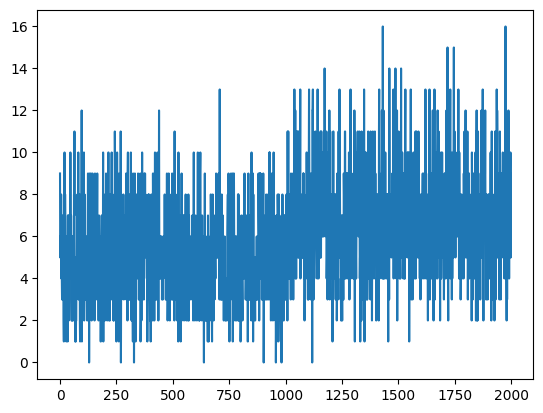

In [162]:
plt.plot(X)

In [163]:
K = 24
R = list(range(len(X)))
g = npConditional(X,K)
beta = 4*log(len(X))
res = pelt(g,R,beta)
cpts(res)

[0, 1009]

In [165]:
class kw :
    def __init__(self,Xs) :
        self.X = Xs
    def __call__(self,i,j) :
        Xstars = [X[i:(j+1)] for X in Xs]
        return log(stats.kruskal(*Xstars).pvalue)
    

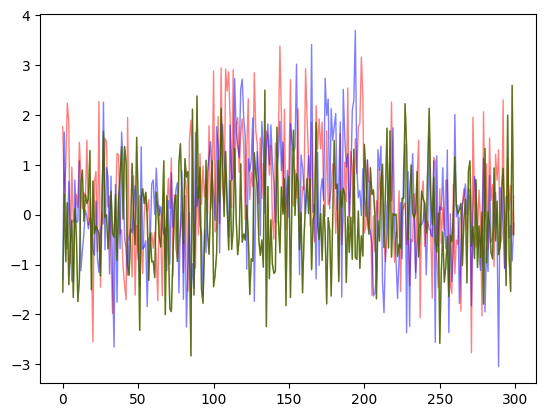

In [166]:
np.random.seed(0)
X1 = [0.0 for i in range(100)] + [1.0 for i in range(100)] + [0.0 for i in range(100)]
E = norm.rvs(size=len(X1))
X1 = [x+e for x,e in zip(X1,E)]
X2 = [0.0 for i in range(100)] + [1 for i in range(100)] + [0.0 for i in range(100)]
E = norm.rvs(size=len(X2))
X2 = [x+e for x,e in zip(X2,E)]
X3 = [0.0 for i in range(100)] + [0.0 for i in range(100)] + [0.0 for i in range(100)]
E = norm.rvs(size=len(X3))
X3 = [x+e for x,e in zip(X3,E)]
X4 = [0.0 for i in range(100)] + [1.0 for i in range(100)] + [0.0 for i in range(100)]
E = norm.rvs(size=len(X4))
X4 = [x+e for x,e in zip(X4,E)]
X5 = [0.0 for i in range(100)] + [1.0 for i in range(100)] + [0.0 for i in range(100)]
E = norm.rvs(size=len(X5))
X5 = [x+e for x,e in zip(X5,E)]
Xs = [X1,X2,X3,X4,X5]

overlapping = 0.5
line1 = plt.plot(X1, c='red', alpha=overlapping, lw=1)
line2= plt.plot(X2 ,c='blue',alpha=overlapping, lw=1)
line3= plt.plot(X3 ,c='green',alpha=overlapping, lw=1)
line4= plt.plot(X3 ,c='yellow',alpha=overlapping, lw=1)
line5= plt.plot(X3 ,c='black',alpha=overlapping, lw=1)



plt.show()


In [167]:
g = kw(Xs)
R = list(range(300))
res = pelt(g,R,2*log(300))
cpts(res)

[0, 96, 200]

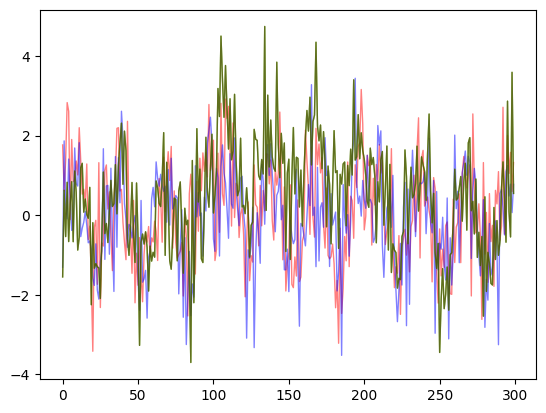

In [168]:
np.random.seed(0)
X1 = [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)]
E = norm.rvs(size=len(X1))
X1 = [x+e for x,e in zip(X1,E)]
X2 = [0.0 + sin(2*pi*i/30) for i in range(100)] + [0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)]
E = norm.rvs(size=len(X2))
X2 = [x+e for x,e in zip(X2,E)]
X3 = [0.0 + sin(2*pi*i/30) for i in range(100)] + [1.5 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)]
E = norm.rvs(size=len(X3))
X3 = [x+e for x,e in zip(X3,E)]
X4 = [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)]
E = norm.rvs(size=len(X4))
X4 = [x+e for x,e in zip(X4,E)]
X5 = [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)]
E = norm.rvs(size=len(X5))
X5 = [x+e for x,e in zip(X5,E)]
Xs = [X1,X2,X3,X4,X5]

overlapping = 0.5
line1 = plt.plot(X1, c='red', alpha=overlapping, lw=1)
line2= plt.plot(X2 ,c='blue',alpha=overlapping, lw=1)
line3= plt.plot(X3 ,c='green',alpha=overlapping, lw=1)
line4= plt.plot(X3 ,c='yellow',alpha=overlapping, lw=1)
line5= plt.plot(X3 ,c='black',alpha=overlapping, lw=1)

In [169]:
g = kw(Xs)
R = list(range(300))
res = pelt(g,R,2*log(300))
cpts(res)

[0, 98, 202]

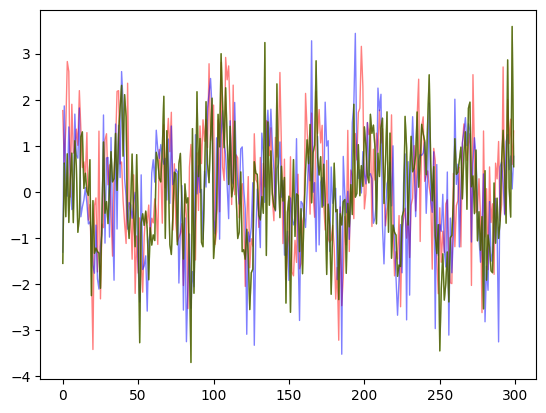

In [170]:
np.random.seed(0)
X1 = [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)]
E = norm.rvs(size=len(X1))
X1 = [x+e for x,e in zip(X1,E)]
X2 = [0.0 + sin(2*pi*i/30) for i in range(100)] + [0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)]
E = norm.rvs(size=len(X2))
X2 = [x+e for x,e in zip(X2,E)]
X3 = [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)]
E = norm.rvs(size=len(X3))
X3 = [x+e for x,e in zip(X3,E)]
X4 = [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)]
E = norm.rvs(size=len(X4))
X4 = [x+e for x,e in zip(X4,E)]
X5 = [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)] + [0.0 + sin(2*pi*i/30) for i in range(100)]
E = norm.rvs(size=len(X5))
X5 = [x+e for x,e in zip(X5,E)]
Xs = [X1,X2,X3,X4,X5]

overlapping = 0.5
line1 = plt.plot(X1, c='red', alpha=overlapping, lw=1)
line2= plt.plot(X2 ,c='blue',alpha=overlapping, lw=1)
line3= plt.plot(X3 ,c='green',alpha=overlapping, lw=1)
line4= plt.plot(X3 ,c='yellow',alpha=overlapping, lw=1)
line5= plt.plot(X3 ,c='black',alpha=overlapping, lw=1)

In [171]:
g = kw(Xs)
R = list(range(300))
res = pelt(g,R,2*log(300))
cpts(res)

[0]

## capa

In [323]:
def capa_norm_mean(X,beta,beta_dash,minseglen=0) :
    S = sop()
    g = normal_mean(X,minseglen)
    R = list(range(len(X)))
    C = lambda i : 0 if i < 0 else S.s(i)[1]
    C1 = lambda i : C(i)
    C2 = lambda i : C(i-1) + X[i]*X[i]
    C3 = lambda i : C(i-1) + beta_dash 
    anoms = point_function()
    anoms.union({(-1,(None,None,None))})
    for r in R :
        S.update(g,[r],beta)
        cs = [C1(r),C2(r),C3(r)]
        c = min(cs)
        t = cs.index(c) + 1
        print(r,t)
        match t :
            case 1 :
                 anoms.union({(r,(S.s(r)[0],S.s(r)[1],1))})
            case 2 :
                S.s.union({(r,(S.s(r)[0],C2(r)))})
                anoms.union({(r,(anoms(r-1)[0],C2(r),2))})  
            case 3 :
                S.s.union({(r,(S.s(r)[0],C3(r)))})
                anoms.union({(r,(r,C3(r),3))}) 
        # print(r,C(r),C2(r),C(r) < C2(r))
        #if C2(r) < C(r) :
        #    S.s.union({(r,(S.s(r)[0],C2(r)))})
        #    anoms.union({(r,(anoms(r-1)[0],C2(r),2))})
        #else :
         #    anoms.union({(r,(S.s(r)[0],S.s(r)[1],1))})
    return anoms

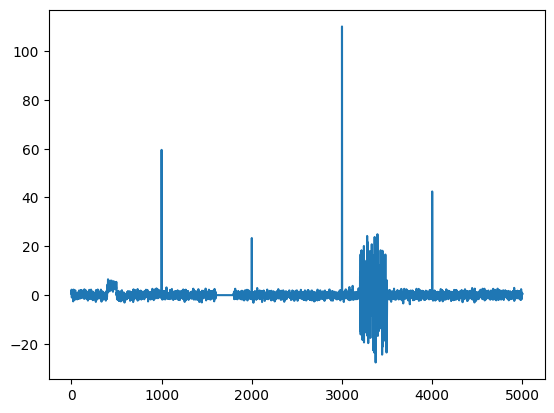

In [326]:
np.random.seed(0)
X = list(norm.rvs(size=5000,loc=0.0,scale=1.0))
X[400:500] = list(norm.rvs(size=100,loc=4.0,scale=1.0))
X[1600:1800] = list(norm.rvs(size=200,loc=0.0,scale=0.01))
X[3200:3500] = list(norm.rvs(size=300,loc=0.0,scale=10))
X[1000] = float(norm.rvs(size=1,loc=0.0,scale=100))
X[2000] = float(norm.rvs(size=1,loc=0.0,scale=100))
X[3000] = float(norm.rvs(size=1,loc=0.0,scale=100))
X[4000] = float(norm.rvs(size=1,loc=0.0,scale=100))

#mu =  median(X)
#sigma = sqrt(variance(Z)) # median_abs_deviation(Z)
#sigma = 1.4826*median_abs_deviation(X) # median_abs_deviation(Z)
#X = [(x-mu)/sigma for x in X] # normalise the data
plt.plot(X)
plt.show()


In [329]:
beta =  4*log(len(X))
beta_dash = 3*log(len(X))
res = capa_norm_mean(X,beta,beta_dash,10)

0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 1
10 2
11 1
12 1
13 2
14 2
15 2
16 1
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 2
43 2
44 2
45 2
46 2
47 2
48 2
49 2
50 2
51 2
52 2
53 2
54 2
55 2
56 2
57 2
58 2
59 2
60 2
61 2
62 2
63 2
64 2
65 2
66 2
67 2
68 2
69 2
70 2
71 2
72 2
73 2
74 2
75 2
76 2
77 2
78 2
79 2
80 2
81 2
82 2
83 2
84 2
85 2
86 2
87 2
88 2
89 2
90 2
91 2
92 2
93 2
94 2
95 2
96 2
97 2
98 2
99 2
100 2
101 2
102 2
103 2
104 2
105 2
106 2
107 2
108 2
109 2
110 2
111 2
112 2
113 2
114 2
115 2
116 2
117 2
118 2
119 2
120 2
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 2
130 2
131 2
132 2
133 2
134 2
135 2
136 2
137 2
138 2
139 2
140 2
141 2
142 2
143 2
144 2
145 2
146 2
147 2
148 2
149 2
150 2
151 2
152 2
153 2
154 2
155 2
156 2
157 2
158 2
159 2
160 2
161 2
162 2
163 2
164 2
165 2
166 2
167 2
168 2
169 2
170 2
171 2
172 2
173 2
174 2
175 2
176 2
177 2
178 2
179 2
180 2
181 2
182 2
183 2
184 2


1503 2
1504 2
1505 2
1506 2
1507 2
1508 2
1509 2
1510 2
1511 2
1512 2
1513 2
1514 2
1515 2
1516 2
1517 2
1518 2
1519 2
1520 2
1521 2
1522 2
1523 2
1524 2
1525 2
1526 2
1527 2
1528 2
1529 2
1530 2
1531 2
1532 2
1533 2
1534 2
1535 2
1536 2
1537 2
1538 2
1539 2
1540 2
1541 2
1542 2
1543 2
1544 2
1545 2
1546 2
1547 2
1548 2
1549 2
1550 2
1551 2
1552 2
1553 2
1554 2
1555 2
1556 2
1557 2
1558 2
1559 2
1560 2
1561 2
1562 2
1563 2
1564 2
1565 2
1566 2
1567 2
1568 2
1569 2
1570 2
1571 2
1572 2
1573 2
1574 2
1575 2
1576 2
1577 2
1578 2
1579 2
1580 2
1581 2
1582 2
1583 2
1584 2
1585 2
1586 2
1587 2
1588 2
1589 2
1590 2
1591 2
1592 2
1593 2
1594 2
1595 2
1596 2
1597 2
1598 2
1599 2
1600 2
1601 2
1602 2
1603 2
1604 2
1605 2
1606 2
1607 2
1608 2
1609 2
1610 2
1611 2
1612 2
1613 2
1614 2
1615 2
1616 2
1617 2
1618 2
1619 2
1620 2
1621 2
1622 2
1623 2
1624 2
1625 2
1626 2
1627 2
1628 2
1629 2
1630 2
1631 2
1632 2
1633 2
1634 2
1635 2
1636 2
1637 2
1638 2
1639 2
1640 2
1641 2
1642 2
1643 2
1644 2
1645 2

2698 2
2699 2
2700 2
2701 2
2702 2
2703 2
2704 2
2705 2
2706 2
2707 2
2708 2
2709 2
2710 2
2711 2
2712 2
2713 2
2714 2
2715 2
2716 2
2717 2
2718 2
2719 2
2720 2
2721 2
2722 2
2723 2
2724 2
2725 2
2726 2
2727 2
2728 2
2729 2
2730 2
2731 2
2732 2
2733 2
2734 2
2735 2
2736 2
2737 2
2738 2
2739 2
2740 2
2741 2
2742 2
2743 2
2744 2
2745 2
2746 2
2747 2
2748 2
2749 2
2750 2
2751 2
2752 2
2753 2
2754 2
2755 2
2756 2
2757 2
2758 2
2759 2
2760 2
2761 2
2762 2
2763 2
2764 2
2765 2
2766 2
2767 2
2768 2
2769 2
2770 2
2771 2
2772 2
2773 2
2774 2
2775 2
2776 2
2777 2
2778 2
2779 2
2780 2
2781 2
2782 2
2783 2
2784 2
2785 2
2786 2
2787 2
2788 2
2789 2
2790 2
2791 2
2792 2
2793 2
2794 2
2795 2
2796 2
2797 2
2798 2
2799 2
2800 2
2801 2
2802 2
2803 2
2804 2
2805 2
2806 2
2807 2
2808 2
2809 2
2810 2
2811 2
2812 2
2813 2
2814 2
2815 2
2816 2
2817 2
2818 2
2819 2
2820 2
2821 2
2822 2
2823 2
2824 2
2825 2
2826 2
2827 2
2828 2
2829 2
2830 2
2831 2
2832 2
2833 2
2834 2
2835 2
2836 2
2837 2
2838 2
2839 2
2840 2

3935 2
3936 2
3937 2
3938 2
3939 2
3940 2
3941 2
3942 2
3943 2
3944 2
3945 2
3946 2
3947 2
3948 2
3949 2
3950 2
3951 2
3952 2
3953 2
3954 2
3955 2
3956 2
3957 2
3958 2
3959 2
3960 2
3961 2
3962 2
3963 2
3964 2
3965 2
3966 2
3967 2
3968 2
3969 2
3970 2
3971 2
3972 2
3973 2
3974 2
3975 2
3976 2
3977 2
3978 2
3979 2
3980 2
3981 2
3982 2
3983 2
3984 2
3985 2
3986 2
3987 2
3988 2
3989 2
3990 2
3991 2
3992 2
3993 2
3994 2
3995 2
3996 2
3997 2
3998 2
3999 2
4000 3
4001 2
4002 2
4003 2
4004 2
4005 2
4006 2
4007 2
4008 2
4009 2
4010 2
4011 2
4012 2
4013 2
4014 2
4015 2
4016 2
4017 2
4018 2
4019 2
4020 2
4021 2
4022 2
4023 2
4024 2
4025 2
4026 2
4027 2
4028 2
4029 2
4030 2
4031 2
4032 2
4033 2
4034 2
4035 2
4036 2
4037 2
4038 2
4039 2
4040 2
4041 2
4042 2
4043 2
4044 2
4045 2
4046 2
4047 2
4048 2
4049 2
4050 2
4051 2
4052 2
4053 2
4054 2
4055 2
4056 2
4057 2
4058 2
4059 2
4060 2
4061 2
4062 2
4063 2
4064 2
4065 2
4066 2
4067 2
4068 2
4069 2
4070 2
4071 2
4072 2
4073 2
4074 2
4075 2
4076 2
4077 2

In [330]:
for i in range(5000) :
    print(i,res(i))

0 (None, 3.111880679314019, 2)
1 (None, 3.2720064707222685, 2)
2 (None, 4.229934512253635, 2)
3 (None, 9.25153684248098, 2)
4 (None, 12.739309689053966, 2)
5 (None, 13.6943817435497, 2)
6 (None, 14.597049744665979, 2)
7 (None, 14.619958749169651, 2)
8 (None, 14.630612880535232, 2)
9 (0, 9.35242200500284, 1)
10 (0, 9.37317055539562, 2)
11 (0, 10.217002469440867, 1)
12 (0, 10.217154305437461, 1)
13 (0, 10.231959115075991, 2)
14 (0, 10.42897368445921, 2)
15 (0, 10.54031224120788, 2)
16 (0, 11.41025306940914, 1)
17 (0, 11.45234298260054, 2)
18 (0, 11.550354368417517, 2)
19 (0, 12.279833900310877, 2)
20 (0, 18.797590900063398, 2)
21 (0, 19.224808168368828, 2)
22 (0, 19.972058110267497, 2)
23 (0, 20.522867027782393, 2)
24 (0, 25.674653080895517, 2)
25 (0, 27.78983259634664, 2)
26 (0, 27.791926438252265, 2)
27 (0, 27.82696423196276, 2)
28 (0, 30.17637635193209, 2)
29 (0, 32.335391546614964, 2)
30 (0, 32.359400251345065, 2)
31 (0, 32.50240714257693, 2)
32 (0, 33.29057067627208, 2)
33 (0, 37.21

## References

[1] _An Algorithm for Optimal Partitioning of
Data on an Interval_ \
Brad Jackson, Jeffrey D. Scargle, David Barnes, Sundararajan Arabhi, Alina Alt, Peter Gioumousis, Elyus Gwin,
Paungkaew Sangtrakulcharoen, Linda Tan, and Tun Tao Tsai 2003  \
**arXiv:math/0309285** 
